In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('housing.data.txt',header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
# 보스턴 교외 지역의 주택 정보에 대한 데이터셋
#CRIM: 도시의 인당 범죄율, 'ZN': 2만5000평방 피트가 넘는 주택 비율, 'INDUS': 도시에서 소매 업종이 아닌 지역 비율
#CHAS: 찰스 강 인접 여부, NOX: 일산화질소 농도, RM: 주택의 평균 방 개수, AGE: 1940년 이전에 지어진 자가 주택 비율
#DIS: 다섯 개의 보스턴 고용 센터까지 가중치가 적용된 거리, RAD: 방사형으로 뻗은 고속도로까지의 접근성 지수
#TAX: 10만 달러당 재산세율, PTRATIO: 도시의 학생-교사 비율, B:1000(BK -0.63)^2, BK는 도시의 아프리카계 미국인 비율
#LSTAT: 저소득 계층의 비율, MEDV: 자가 주택의 중간 가격
#타깃은 MEDV(주택 가격)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


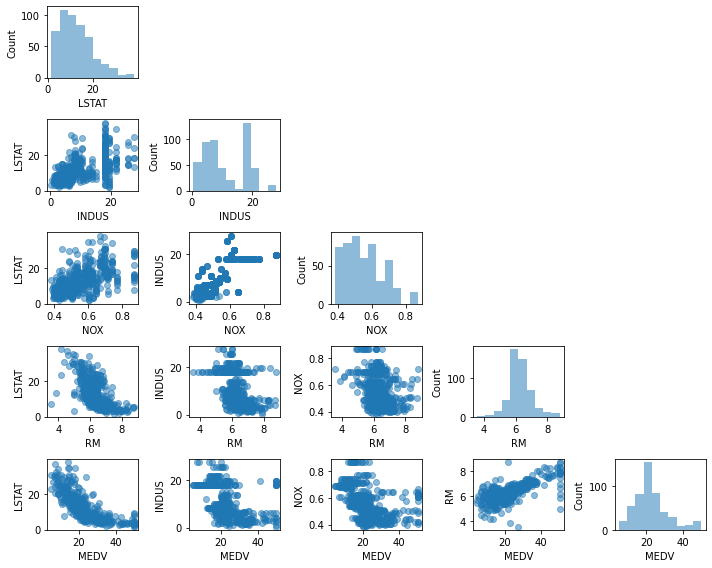

In [4]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

#mlxtend를 이용하여 특성들 간의 상관관계를 시각화
cols = ['LSTAT', 'INDUS', 'NOX','RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10,8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

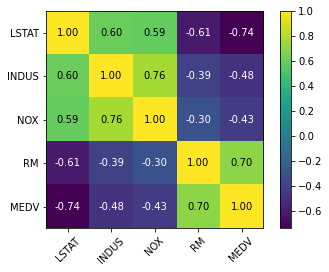

In [7]:
from mlxtend.plotting import heatmap
import numpy as np

#heatmap을 이용하여 특성들간의 상관관계(계수) 행렬을 시각화
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

x=df[['RM']].values
y=df['MEDV'].values
lr = LinearRegression()
lr.fit(x,y)
print('grad: %.3f, intercept: %.3f' %(lr.coef_[0], lr.intercept_))

grad: 9.102, intercept: -34.671


In [9]:
def lin_plot(x, y, model):
    plt.scatter(x, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(x, model.predict(x), color='black', lw=2)
    return None

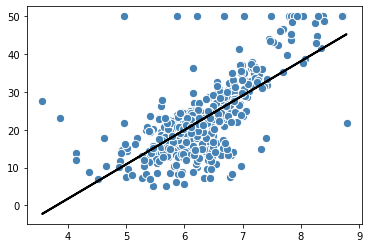

In [10]:
lin_plot(x, y, lr)

In [12]:
#RANSAC(RANDOM SAMPLE Consensus)를 이용하여 이상치를 제거하지 않고 정상치의 데이터로만 모델을 훈련할 수 있음
#이 모델은 랜덤하게 일부 샘플을 정상치로 선택하여 훈련한 후, 나머지 샘플에 대해 테스트한 후,
#사용자가 입력한 허용 오차 안에 속한 포인트만 정상치에 추가한 후, 모든 정상치를 사용하여 모델을 다시 훈련함
from sklearn.linear_model import RANSACRegressor

ransac=RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, loss='absolute_loss', residual_threshold=5.0, random_state=0)
ransac.fit(x,y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

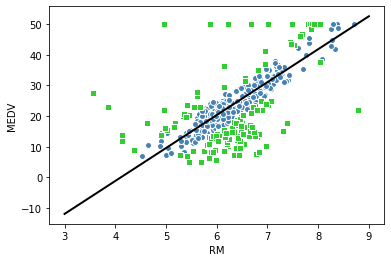

In [15]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_x = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_x[:, np.newaxis])
plt.scatter(x[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='inliers')
plt.scatter(x[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='outliers')
plt.plot(line_x, line_y_ransac, color='black', lw=2)
plt.xlabel('RM')
plt.ylabel('MEDV')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, :-1].values
y = df['MEDV'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

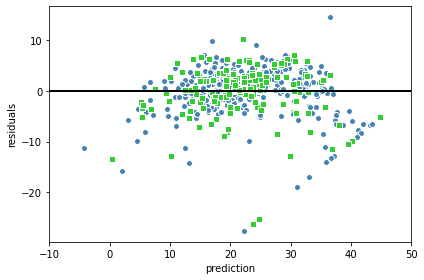

In [17]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='steelblue', marker='o', edgecolor='white', label='train data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen',marker='s', edgecolor='white', label='test data')
plt.xlabel("prediction")
plt.ylabel("residuals")
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()
#잘 훈련된 회귀 모델이라면 오차가 랜덤하게 분포해야함. 잔차에 어떤 경향성이 나타나면 특정한 정보를 잡아내지 못한것임.

In [18]:
from sklearn.metrics import mean_squared_error
print("train MSE: %.3f, test MSE: %.3f: "%(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

train MSE: 19.958, test MSE: 27.196: 


In [20]:
#mse(평균 제곱 오차)는 특성의 스케일에 영향을 받음. 따라서, 결정 계수가 더 유용할 수 있음
#결정 계수는 평균 제곱 오차의 표준화된 버전으로 생각할 수 있음
#R^2 = 1-(SSE/SST) SSE는 제곱 오차합, SST는 전체 제곱합(타깃의 분산), 결정 계수가 클수록 모델의 성능이 높음
from sklearn.metrics import r2_score
print("train r: %.3f, test r: %.3f" %(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

train r: 0.765, test r: 0.673


In [22]:
from sklearn.preprocessing import PolynomialFeatures
x=np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y=np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
x_quad = quadratic.fit_transform(x)

In [23]:
lr.fit(x,y)
x_fit=np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(x_fit)

In [24]:
pr.fit(x_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(x_fit))

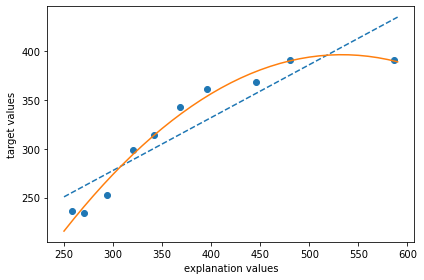

In [26]:
plt.scatter(x, y, label='training points')
plt.plot(x_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(x_fit, y_quad_fit, label='quadratic fit')
plt.xlabel('explanation values')
plt.ylabel('target values')
plt.tight_layout()
plt.show()

In [27]:
y_lin_pred = lr.predict(x)
y_quad_pred = pr.predict(x_quad)
print("train MSE, linear: %.3f, quadratic: %.3f" %(mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred)))
print("train R^2, linear: %.3f, quadratic: %.3f" %(r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))

train MSE, linear: 569.780, quadratic: 61.330
train R^2, linear: 0.832, quadratic: 0.982


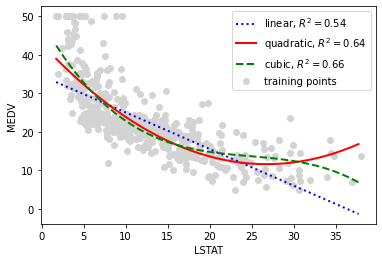

In [35]:
x = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
x_quad = quadratic.fit_transform(x)
x_cubic = cubic.fit_transform(x)

x_fit = np.arange(x.min(), x.max(), 1)[:, np.newaxis]
regr = regr.fit(x,y)
y_lin_fit = regr.predict(x_fit)
linear_r2 = r2_score(y, regr.predict(x))

regr = regr.fit(x_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(x_fit))
quadratic_r2 = r2_score(y, regr.predict(x_quad))

regr = regr.fit(x_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(x_fit))
cubic_r2 = r2_score(y, regr.predict(x_cubic))

plt.scatter(x, y, label='training points', color='lightgray')

plt.plot(x_fit, y_lin_fit, label='linear, $R^2=%.2f$' %linear_r2, color='blue', lw=2, linestyle=':')
plt.plot(x_fit, y_quad_fit, label='quadratic, $R^2=%.2f$' %quadratic_r2, color='red', lw=2, linestyle='-')
plt.plot(x_fit, y_cubic_fit, label='cubic, $R^2=%.2f$' %cubic_r2, color='green', lw=2, linestyle='--')

plt.xlabel('LSTAT')
plt.ylabel("MEDV")
plt.legend(loc='upper right')
plt.show()

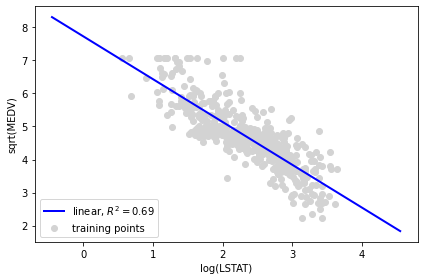

In [38]:
x_log = np.log(x)
y_sqrt = np.sqrt(y)

x_fit = np.arange(x_log.min()-1, x_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(x_log, y_sqrt)
y_lin_fit = regr.predict(x_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(x_log))
plt.scatter(x_log, y_sqrt, label='training points', color='lightgray')
plt.plot(x_fit, y_lin_fit, label='linear, $R^2=%.2f$' %linear_r2, color='blue', lw=2)
plt.xlabel('log(LSTAT)')
plt.ylabel('sqrt(MEDV)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

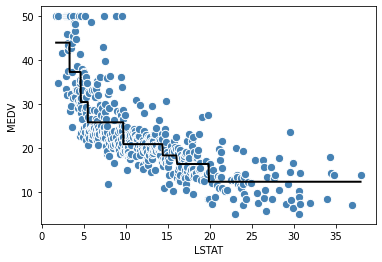

In [39]:
#비선형 회귀에도 랜덤 포레스트를 사용할 수 있음. 랜덤포레스트는 개별 선형 함수의 합으로 이해할 수 있음. 
#데이터셋을 학습하기 좋은 더 작은 영역으로 분할하는 것임.
#결정트리엔 불순도 지표가 필요한데, 연속적인 특성에 대한 불순도 지표가 필요하므로 MSE를 노드의 불순도 지표로 정의함
#결정 트리 회귀에선 MSE를 종종 노드 내 분산(within-node variance)라고도 부르고, 분할 기준을 분산 감소라고도 부름
from sklearn.tree import DecisionTreeRegressor
x=df[['LSTAT']].values
y=df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(x,y)
sort_idx = x.flatten().argsort()
lin_plot(x[sort_idx], y[sort_idx], tree)
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.show()

In [44]:
x = df.iloc[:, :-1].values
y = df['MEDV'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=1)

#randomforestregressor의 criterion(개별 트리 성장 기준) default='squared_error'
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, random_state=1, n_jobs=-1)
forest.fit(x_train,y_train)
y_train_pred = forest.predict(x_train)
y_test_pred = forest.predict(x_test)
print("train mse: %.3f, test mse: %.3f" %(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print("train R^2: %.3f, test R^2: %.3f" %(r2_score(y_train,y_train_pred), r2_score(y_test, y_test_pred)))

train mse: 1.644, test mse: 11.085
train R^2: 0.979, test R^2: 0.877


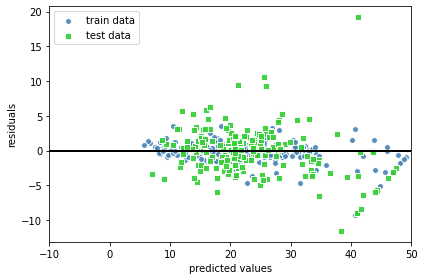

In [45]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9, label='train data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9, label='test data')
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()
#이상적으로는 모델의 오차가 랜덤하거나 예측할 수 없어야함. 즉 잔차 그래프에 어떤 패턴이 있으면 안됨
#잔차 그래프에 패턴이 있다는 건 어떤 특성의 정보가 잔차로 누설되는 것임. 이러한 특성을 실험을 통해 알아내야 함